In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import nir
import numpy as np

import spyx

In [2]:
input_data = jnp.transpose(jnp.array(np.load("val_numbers.npy"), dtype=jnp.float32), axes=(1,0,2,3,4))

In [3]:
input_data.shape # had to transpose data because it's stored in time-major format...

(10, 300, 2, 34, 34)

In [4]:
ng = nir.read("scnn_mnist.nir")

In [5]:
layers_to_grab = ["input", "0", "1", "output"]
new_nodes = {k:ng.nodes[k] for k in layers_to_grab}
new_edges = [("input", "0"), ("0","1"), ("1", "output")]
first_conv = nir.NIRGraph(new_nodes, new_edges)
first_conv.nodes["output"].output_type["output"] = np.array([16,16,16])

In [6]:
fl_SNN, fl_params = spyx.nir.from_nir(first_conv, input_data, dt=1, return_all_states=True)

In [7]:
output_spikes, membrane_potentials = fl_SNN.apply(fl_params, input_data)

In [8]:
save_data = np.array(jnp.transpose(output_spikes, (1,0,2,3,4)))
save_data.shape

(300, 10, 16, 16, 16)

In [9]:
spyx_act = jnp.sum(output_spikes[0], axis=0)

In [10]:
spyx_act.shape

(16, 16, 16)

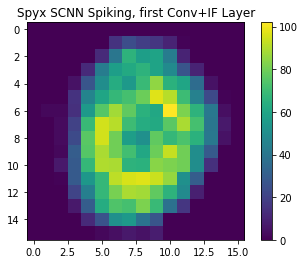

In [11]:
plt.imshow(jnp.sum(spyx_act, axis=(0)))
plt.colorbar()
plt.title("Spyx SCNN Spiking, first Conv+IF Layer")
plt.show()

In [12]:
import numpy as np

snntorch_act = np.sum(np.load("./snnTorch_activity.npy", "r"), axis=0)

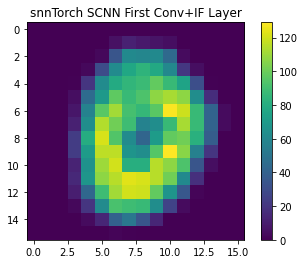

In [13]:
plt.imshow(jnp.sum(snntorch_act[0], axis=(0)))
plt.colorbar()
plt.title("snnTorch SCNN First Conv+IF Layer")
plt.show()

In [14]:
def cosine_similarity(vector1, vector2):
    # Compute the dot product of the two vectors
    dot_product = jnp.dot(vector1, vector2)

    # Compute the magnitude (L2 norm) of each vector
    magnitude1 = jnp.linalg.norm(vector1)
    magnitude2 = jnp.linalg.norm(vector2)

    # Compute the cosine similarity
    similarity = dot_product / (magnitude1 * magnitude2)

    return similarity

In [15]:
cosine_similarity(jnp.sum(spyx_act, 0).flatten(), jnp.sum(snntorch_act[0], 0).flatten())

Array(0.9865636, dtype=float32)

In [16]:
np.save("spyx_activity.npy", save_data)

## Inference Accuracy

In [17]:
import tonic
import torch

bs = 128
collate = tonic.collation.PadTensors(batch_first=False)
to_frame = tonic.transforms.ToFrame(sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3)
test_ds = tonic.datasets.NMNIST("./nmnist", transform=to_frame, train=False)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=bs, collate_fn=collate)


In [18]:
SNN, params = spyx.nir.from_nir(ng, input_data, dt=1)

In [19]:
accs = []
for (x, y) in test_dl:
    x = jnp.transpose(jnp.array(x), (1,0,2,3,4))
    spikes, V = SNN.apply(params, x)
    acc, preds = spyx.fn.integral_accuracy(spikes, jnp.array(y))
    accs.append(acc)

In [20]:
final_acc = np.mean(np.array(accs))
final_acc

0.9713212

In [21]:
np.save("spyx_accuracy.npy", final_acc)